In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import base64
from io import BytesIO

Reporte completo generado como 'reporte_completo_pronostico.html'


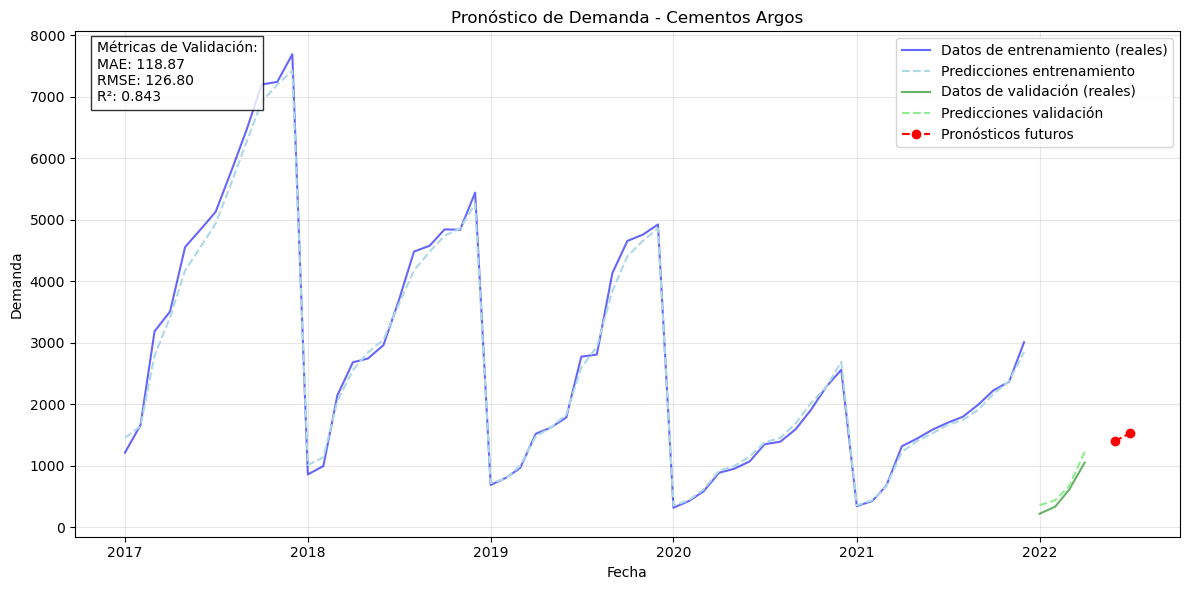

In [46]:
# 1. Cargar y preparar datos
demand_df = pd.read_csv('dataset_demand_acumulate.csv')
demand_df['year_month'] = pd.to_datetime(demand_df['year_month'])
demand_df['month'] = demand_df['year_month'].dt.month
demand_df['year'] = demand_df['year_month'].dt.year

# 2. División de datos
train_data = demand_df[demand_df['year_month'] < '2022-01']
validation_data = demand_df[demand_df['year_month'] >= '2022-01']

# 3. Preparar features y entrenar modelo
features = ['month', 'year']
X_train = train_data[features]
y_train = train_data['Demand']
X_val = validation_data[features]
y_val = validation_data['Demand']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Generar predicciones
val_predictions = model.predict(X_val)
train_predictions = model.predict(X_train)

# 5. Calcular métricas
metrics = {
    'MAE': mean_absolute_error(y_val, val_predictions),
    'RMSE': np.sqrt(mean_squared_error(y_val, val_predictions)),
    'R2': r2_score(y_val, val_predictions)
}

# 6. Generar pronósticos futuros
future_dates = pd.date_range(start='2022-05', end='2022-07', freq='M')
future_data = pd.DataFrame({
    'year_month': future_dates,
    'month': future_dates.month,
    'year': future_dates.year
})
future_predictions = model.predict(future_data[features])

# 7. Crear gráfico
plt.figure(figsize=(12, 6))

# Plotear datos
line1, = plt.plot(train_data['year_month'], train_data['Demand'], 
                 color='blue', alpha=0.6)
line2, = plt.plot(train_data['year_month'], train_predictions, 
                 color='lightblue', linestyle='--')
line3, = plt.plot(validation_data['year_month'], validation_data['Demand'], 
                 color='green', alpha=0.6)
line4, = plt.plot(validation_data['year_month'], val_predictions, 
                 color='lightgreen', linestyle='--')
line5, = plt.plot(future_dates, future_predictions, 
                 color='red', linestyle='--', marker='o')

plt.title('Pronóstico de Demanda - Cementos Argos')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend([line1, line2, line3, line4, line5],
          ['Datos de entrenamiento (reales)', 
           'Predicciones entrenamiento',
           'Datos de validación (reales)',
           'Predicciones validación',
           'Pronósticos futuros'])

# Agregar métricas al gráfico
metrics_text = '\n'.join([
    'Métricas de Validación:',
    f'MAE: {metrics["MAE"]:,.2f}',
    f'RMSE: {metrics["RMSE"]:,.2f}',
    f'R²: {metrics["R2"]:.3f}'
])
plt.text(0.02, 0.98, metrics_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.grid(True, alpha=0.3)
plt.tight_layout()

# Guardar gráfico en formato base64
buffer = BytesIO()
plt.savefig(buffer, format='png', dpi=300, bbox_inches='tight')
buffer.seek(0)
image_base64 = base64.b64encode(buffer.getvalue()).decode()

# 8. Preparar datos completos
full_results = pd.concat([
    demand_df,
    pd.DataFrame({
        'year_month': future_dates,
        'Demand': future_predictions,
        'month': future_dates.month,
        'year': future_dates.year,
        'tipo': 'pronóstico'
    })
])

full_results.loc[full_results['year_month'] < '2022-01', 'tipo'] = 'entrenamiento'
full_results.loc[(full_results['year_month'] >= '2022-01') & 
                (full_results['year_month'] <= '2022-04'), 'tipo'] = 'validación'

# 9. Generar reporte HTML
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Reporte de Pronóstico de Demanda</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 20px;
            max-width: 1200px;
            margin: auto;
        }}
        .header {{
            text-align: center;
            margin-bottom: 30px;
        }}
        .metrics {{
            margin: 20px 0;
            padding: 15px;
            background-color: #f8f9fa;
            border-radius: 5px;
        }}
        table {{
            width: 100%;
            border-collapse: collapse;
            margin-top: 20px;
        }}
        th, td {{
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }}
        th {{
            background-color: #f8f9fa;
        }}
        .graph {{
            text-align: center;
            margin: 30px 0;
        }}
        img {{
            max-width: 100%;
            height: auto;
        }}
    </style>
</head>
<body>
    <div class="header">
        <h1>Reporte de Pronóstico de Demanda - Cementos Argos</h1>
        <p>Generado el {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}</p>
    </div>

    <div class="graph">
        <h2>Visualización del Pronóstico</h2>
        <img src="data:image/png;base64,{image_base64}" alt="Gráfico de pronóstico">
    </div>

    <div class="metrics">
        <h2>Métricas de Validación</h2>
        <ul>
            <li>MAE (Error Absoluto Medio): {metrics['MAE']:,.2f}</li>
            <li>RMSE (Error Cuadrático Medio): {metrics['RMSE']:,.2f}</li>
            <li>R² (Coeficiente de Determinación): {metrics['R2']:.3f}</li>
        </ul>
    </div>

    <h2>Datos Completos</h2>
    {full_results.to_html(index=False, float_format=lambda x: '{:,.2f}'.format(x) if isinstance(x, (float, int)) else x)}
</body>
</html>
"""

# Guardar reporte HTML
with open('reporte_completo_pronostico.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print("Reporte completo generado como 'reporte_completo_pronostico.html'")